# Single-Cell Preprocessing

This file provides preprocessing as is standard in single cell preprocessing roughly following:

M.D. Luecken, F.J. Theis, "Current best practices in single-cell RNA-seq analysis: a tutorial", Molecular Systems Biology 15(6) (2019): e8746



In [9]:
import scanpy as sc
import scirpy as ir

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from matplotlib import rcParams

## Paths

We want to save intermediate preprocessing results, so that we can start from this point later. 

In [21]:
path_base = '../data/raw_data/thymus_annotated_matrix_files/HTA08.v01.A06.Science_human_tcells.h5ad'
path_filtered = '../data/01_filtered_data.h5ad'
path_normalized = '../data/02_normalized_data.h5ad'
path_high_var = '../data/03_variableGenes_data.h5ad'
path_tcr = '../data/04_merged_data.h5ad'
path_tcr_filtered = '../data/05_tcr_filtered_data.h5ad'
path_tcr_anno = '../data/06_tcr_annotation_data.h5ad'


## Reading adata Object
The data is stored in an annotated data object (https://anndata.readthedocs.io/en/latest/) with .h5ad extension. We use Scanpy (https://scanpy.readthedocs.io/en/stable/) to load the data.

In [3]:
adata = sc.read_h5ad(path_base)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
print('Amount cells: ', adata.X.shape[0])
print('Amount genes: ', adata.X.shape[1])

Amount cells:  76994
Amount genes:  33694


In [11]:
print('Annotations per Cell: ')
adata.var_names_make_unique()
adata.obs.head(5)

Annotations per Cell: 


,Sample,donor,organ,sort,method,file,is_TRA_p,is_TRB_p,is_TRA_np,is_TRB_np,Age,Source,cell types,n_counts,log_counts,n_genes,mt_fraction
index,,,,,,,,,,,,,,,,,
FCAImmP7179369-AAACCTGAGCCCAATT,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,CD8+T,5762.440430,3.760607,1898,0.009007
FCAImmP7179369-AAACCTGAGCCTATGT,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,CD4+T,4585.666992,3.661402,1210,0.011306
FCAImmP7179369-AAACCTGAGTCGCCGT,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,DP(P),8521.404297,3.930511,3153,0.006470
FCAImmP7179369-AAACCTGCAGCATGAG,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,CD8+T,6566.304688,3.817321,2387,0.008715
FCAImmP7179369-AAACCTGGTCTCCCTA,F21_TH_45P,F21,TH,45P,3GEX,FCAImmP7179369,False,False,False,False,16w,HDBR,CD8αα(I),7198.029785,3.857214,2439,0.008274


## Quality Control
Due to sequencing errors / artefacts, several samples in the adata object are invalid. This might occure due to multiple cells in the same droplet (duplets), dieing cells, empty droplets, ... 

In order to filter these cells, we apply several filters on the following quantities:
- n_counts: amount of measured genes per cell
- n_genes: amount of different genes measured in a cell
- mt_frac: fraction of mitochondrial genes (high fraction indicates dieing cells)

In [12]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(axis=1) / adata.X.sum(axis=1)

Visualize with violin plots to understand the distributation.

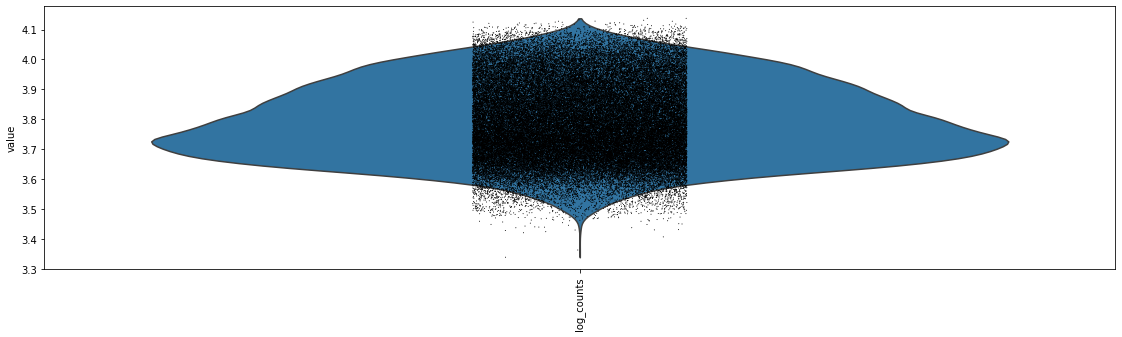

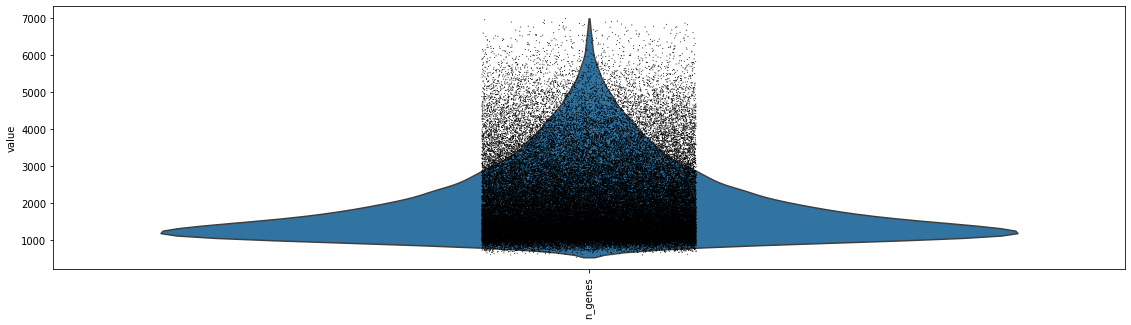

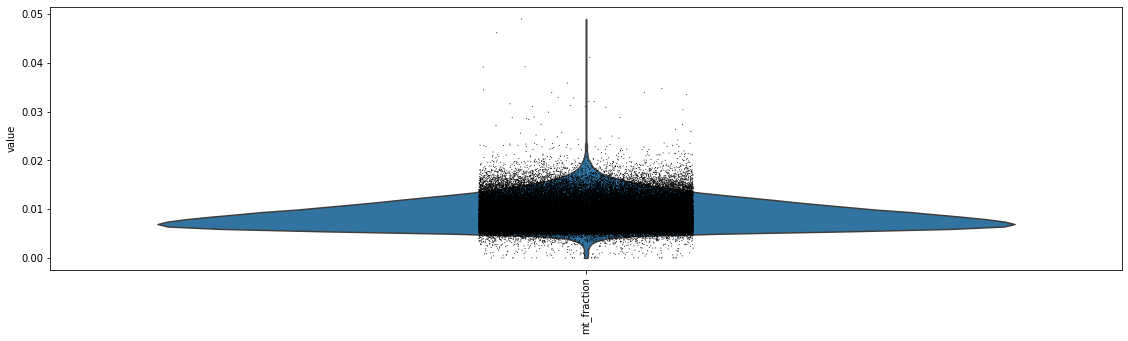

In [14]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_fraction'], size=1, log=False, rotation=90)

Joint visualisation for filtering:

<Axes:title={'center':'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

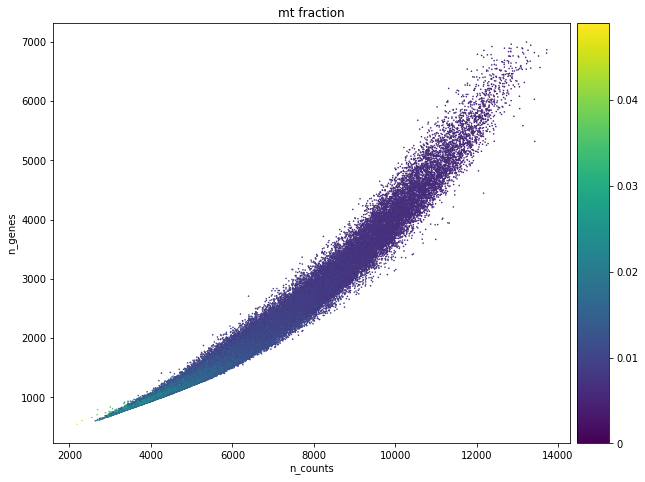

In [15]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

Apply Filter with values from paper / "standard" values:
(This is not very sensible, since the dataset is already "cleaned". However, it shows how this pipeline would typically be applied to a novel dataset.

In [16]:
print('Number of cells: ', len(adata))
mask_mt = adata.obs['mt_fraction'] < 0.2  # Only kepp cells with mt fraction smaller than 0.2
adata = adata[mask_mt]
print('Number of cells after mt-filter: ', len(adata))

Number of cells:  76994
Number of cells after mt-filter:  76994


C:\Users\felix.drost\Anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
adata = adata[adata.obs['n_genes']>500]
print('Number of cells after low gene filter: ', len(adata))
adata = adata[adata.obs['n_genes']<7000]
print('Number of cells after high gene filter: ', len(adata))

Number of cells after low gene filter:  76994
Number of cells after high gene filter:  76994


C:\Users\felix.drost\Anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\felix.drost\Anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
adata = adata[adata.obs['n_counts']>2000]
print('Number of cells after low count filter: ', len(adata))

Number of cells after low count filter:  76994


C:\Users\felix.drost\Anaconda3\envs\thymusTCRs\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
sc.write(adata=adata, filename=path_filtered)

## Normalization
To account for different amount of count detected for each cell, we normalize the counts to 10000. Most algorithms are performed not on raw counts but on log1p transformed values

In [22]:
adata = sc.read(path_filtered)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.write(adata=adata, filename=path_normalized)

## Highly Variable Genes
Many genes are not particualary interesting, when they occur in all cells in the dataset. Therefore, we reduce the dataset to contain only the 5000 genes, that are the most variable.

In [24]:
adata = sc.read(path_normalized)
print('Shape before Highly Variable Gene selection', adata.shape)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
adata = adata[:, adata.var['highly_variable']]
print('Shape after Highly Variable Gene selection', adata.shape)
sc.write(adata=adata, filename=path_high_var)

Shape before Highly Variable Gene selection (76994, 33694)
Shape after Highly Variable Gene selection (76994, 5000)


## Merge with TCR data

The adata object contains only the scRNA data (transcriptome) for each cell. We need to fuse that with the TCR data from folder '../data/raw_data/thymus_paper_vdj'. 
Hint:
- Use scirpy (https://icbi-lab.github.io/scirpy/latest/) an extension of scanpy for TCR analysis
- Use the description of the dataset from (https://zenodo.org/record/5500511#.YYqg67oxkUE) 
- Use 'sample_metadata_fix.xlsx' for matching the experiments between scRNA and tcr
- Have a look on the barcodes in both dataset (adata_rna.index, adata_tcr.index) and transform them to the same format

In [ ]:
adata_rna = sc.read(path_high_var)
# todo merge adata_rna with tcr data
# and save to adata object 04


## TCR filter
For applying mvTCR only cells with exactly 1 TCRalpha and 1 TCRbeta chains can be used. Therefore, we need to filter out the incomplete cells.

In [25]:
adata = sc.read(path_tcr)
# TODO: filter the adata_object to contain exactly one single TCR
# and save to adata object 05

## TCR Annotation
mvTCR requires a specific annotation for each cells. Hint:
- Use the preprocessing scripts from (https://github.com/SchubertLab/mvTCR)
- Use the functions provided in tcr_embedding.utils_preprocessing

In [ ]:
adata = sc.read(path_filtered)
# TODO: annotate the TCR data so it can be used by mvTCR
# and save to adat object 06